## Smoothed L0 Optimisation algorithm. 

SL0 can be used to find the sparsest solution of an underdetermined system of linear equations.
The main idea is to smooth the discontinuity of the L0 norm, so that we can directly optimize it
using gradient ascent. Local minima are escaped using a Gratuated Non-Convexity (GNC) procuedure.

See details:
  - Hossein Mohimani, Massoud Babaie-Zadeh, Christian Jutten, "Fast Sparse Representation based on Smoothed L0 norm", in proceedings of 7th International Conference on Independent Component Analysis and Signal Separation (ICA2007), LNCS 4666, September 2007, London, pp. 389-396
  - Hossein Mohimani, Massoud Babaie-Zadeh, Christian Jutten, "A fast approach for overcomplete sparse decomposition based on smoothed L0 norm", IEEE Transactions on Signal Processing, Vol.57, No.1, January 2009, pp. 289-301
  - Hossein Mohimani, Massoud Babaie-Zadeh, Christian Jutten, "Complex-Valued Sparse Representation Based on Smoothed L0 Norm" in proceedings of ICASSP2008, Las Vegas, April 2008, pp. 3881-3884
  - Hossein Mohimani, Massoud Babaie-Zadeh, Irina Gorodnitsky, Christian Jutten, "Sparse Recovery using Smoothed L0 (SL0): Convergence Analysis" submitted (on 24 January 2010) to IEEE Transactions on Information Theorey

## Algorithm

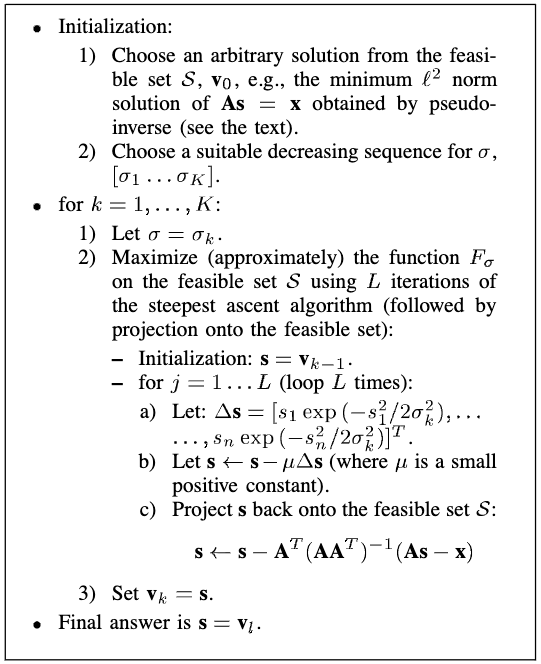

## Numpy Implementation

In [1]:
import numpy as np

In [2]:
def smoothing(x, sigma):
    """Implements the smoothing function (based on gaussian) for maximization"""
    x_abs = np.abs(x)
    return (x * (np.exp(-1 * x_abs * x_abs / (2 * sigma * sigma))))

def SL0(A, b, sigma_min, L=3, lr=2, decrease=0.5):
    """Function that performs the SL0 algorithm.

    """
    A_pseudo = np.linalg.pinv(A)
    s = np.matmul(A_pseudo, b)
    sigma = 2 * np.max(np.abs(s))

    while sigma > sigma_min:
        for i in range(L):
            delta = smoothing(s, sigma)
            s -= lr * delta
            s -= np.matmul(A_pseudo, (np.matmul(A, s) - b)) 
            
        sigma *= decrease
    return np.around(s, decimals=10) 

In [3]:
A = [[1, 2, 1, 1], [1, -1, 2, -2]]
b = [4, -2]
sigma_min = 1e-12

In [4]:
%%time
s = SL0(A, b, sigma_min)

CPU times: user 7.73 ms, sys: 106 µs, total: 7.83 ms
Wall time: 30.3 ms


In [5]:
s

array([ 0.,  2., -0., -0.])

In [6]:
np.linalg.norm(s, ord=0)

1.0

In [7]:
n = 4000
m = 10000
A = np.random.random([n, m])
b = np.random.random(n)

In [8]:
%%time
s = SL0(A, b, sigma_min, L=100)

CPU times: user 10min 45s, sys: 14.9 s, total: 11min
Wall time: 5min 39s


In [9]:
np.linalg.norm(s, ord=0)

4286.0

## PyTorch Implementation

In [10]:
import functools
import torch

In [11]:
def smoothing_torch(x, sigma):
    """Implements the smoothing function (based on gaussian) for maximization"""
    x_abs = torch.abs(x)
    return (x * (torch.exp(-1 * x_abs * x_abs / (2 * sigma * sigma))))

def SL0_torch(A, b, sigma_min, L=3, lr=2, decrease=0.5):
    """Function that performs the SL0 algorithm.

    """
    with torch.no_grad():
        A_pseudo = torch.pinverse(A)
        s = A_pseudo @ b
        sigma = 2 * torch.max(torch.abs(s))

        while sigma > sigma_min:
            for i in range(L):
                delta = smoothing_torch(s, sigma)
                s -= lr * delta
                s -= A_pseudo @ ((A @ s) - b)

            sigma *= decrease

        n_digits = 5
        return torch.round(s * 10 ** n_digits) / (10 ** n_digits)

In [12]:
A = [[1, 2, 1, 1], [1, -1, 2, -2]]
b = [4, -2]
A, b = map(functools.partial(torch.tensor, dtype=torch.float32), (A, b))
sigma_min = 1e-12

In [13]:
%%time
s = SL0_torch(A, b, sigma_min)

CPU times: user 15.6 ms, sys: 1.11 ms, total: 16.7 ms
Wall time: 255 ms


In [14]:
s

tensor([0., 2., -0., -0.])

In [15]:
np.linalg.norm(s.numpy(), ord=0)

1.0

In [16]:
n = 4000
m = 10000
A = torch.rand([n, m]).cuda()
b = torch.rand(n).cuda()

In [17]:
%%time
s = SL0_torch(A, b, sigma_min, L=100)

CPU times: user 17.2 s, sys: 5.1 s, total: 22.4 s
Wall time: 22.6 s


In [19]:
np.linalg.norm(s.cpu().numpy(), ord=0)

3953.0